In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from wordcloud import WordCloud

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [3]:
import pandas as pd

file_path = 'train.txt'  # Replace with your actual file path

# Load the data into a pandas DataFrame
df = pd.read_csv('train.txt', sep=';', header=None, names=['content', 'sentiment'])
df2 = pd.read_csv('val.txt', sep=';', header=None, names=['content', 'sentiment'])
df3 = pd.read_csv('test.txt', sep=';', header=None, names=['content', 'sentiment'])
df = pd.concat([df,df2,df3])
# Strip any leading/trailing whitespace characters from the data
df['content'] = df['content'].str.strip()
df['sentiment'] = df['sentiment'].str.strip()

# Show the DataFrame
print(df.head())

                                             content sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df.shape

(20000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [7]:
df.isnull().sum()

content      0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()

1

In [9]:
#df.drop('tweet_id', axis=1, inplace=True)

In [10]:
df['sentiment'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: sentiment, dtype: int64

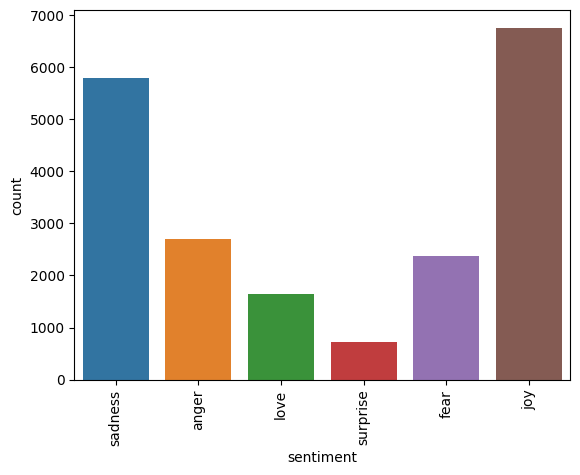

In [11]:
sns.countplot(x=df['sentiment'])
plt.xticks(rotation=90)
plt.show()

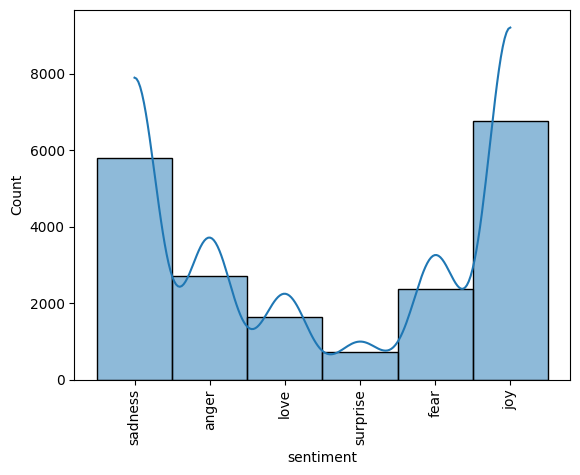

In [12]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/kjf4ec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kjf4ec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kjf4ec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kjf4ec/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Remove junk

In [15]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [16]:
df = text_preprocessing_platform(df, 'content', remove_stopwords=True)

In [17]:
df.head()

,content,sentiment
0,feel humiliate,sadness
1,go feel hopeless damn hopeful around someone c...,sadness
2,grab minute post feel greedy wrong,anger
3,ever feel nostalgic fireplace know still property,love
4,feel grouchy,anger


In [18]:
df['sentiment'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: sentiment, dtype: int64

In [19]:
df = df[df['sentiment'] != 'surprise']

# Balance data

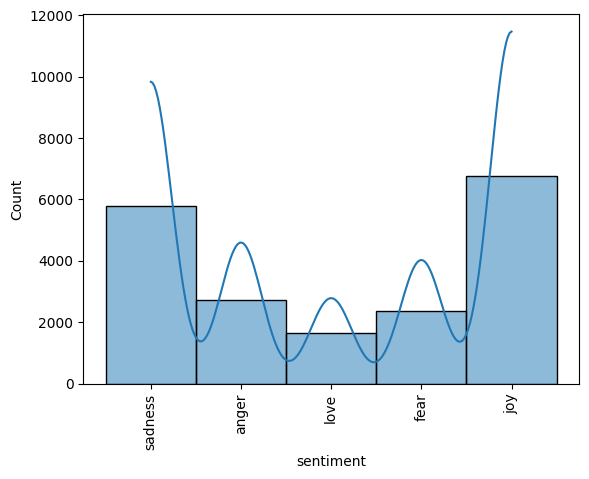

In [20]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [21]:
df['sentiment'].value_counts()

joy        6761
sadness    5797
anger      2709
fear       2373
love       1641
Name: sentiment, dtype: int64

In [23]:
label_mapping = {'joy':0, 'sadness':1, 'anger':2, 'fear':3, 'love':4}
df['sentiment'] = df['sentiment'].map(label_mapping)

In [24]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 13496; Test: 5785


In [25]:
train_df

,content,sentiment
10200,feel thankful everything life every day,0
1875,feel bite like franz liebkind producers many p...,0
50,stand finally stand feel like punish could go ...,1
14921,start feel unsure,3
11467,feel afraid live alone live far,3
...,...,...
11708,feel absolutely overwhelm,3
12417,would feel hesitant use medical system need,3
5623,feel love bless thank allah,4
902,funeral friend kill car accident age,1


In [26]:
X_train = train_df['content'].values
y_train = train_df['sentiment'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 13496; X_test: 4338; X_valid: 1447
y_train: 13496; y_test: 4338; y_valid: 1447


In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [28]:
labels = df['sentiment'].unique()

In [29]:
from transformers import RobertaTokenizerFast

In [30]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

In [31]:
is_train=True

In [32]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


In [33]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
test_df['sentiment'] = label_encoder.transform(test_df['sentiment'])
val_df['sentiment'] = label_encoder.transform(val_df['sentiment'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['sentiment'].values)
y_test = torch.tensor(test_df['sentiment'].values)
y_valid = torch.tensor(val_df['sentiment'].values)

# Batch size: 64 Learning Rate: 1e-6

In [34]:
model_name = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Define the RoBERTa model and tokenizer
def tokenize_text(text):
    tokens = tokenizer_roberta.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['sentiment'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['sentiment'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['sentiment'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)
valid_dataset = TensorDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [35]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, valid_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)
    
test_cm, test_report = evaluate(model, test_dataloader)
    
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)

valid_cm, valid_report = evaluate(model, valid_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

Epoch 1/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.35it/s]


Training Loss: 1.5233


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.51it/s]


Validation Loss: 1.5754
Epoch 2/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.37it/s]


Training Loss: 1.4889


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.33it/s]


Validation Loss: 1.5771
Epoch 3/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.36it/s]


Training Loss: 1.4782


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.32it/s]


Validation Loss: 1.5686
Epoch 4/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.35it/s]


Training Loss: 1.4123


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.28it/s]


Validation Loss: 1.5596
Epoch 5/10


Training: 100%|██████████| 211/211 [01:03<00:00,  3.35it/s]


Training Loss: 1.0323


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.29it/s]


Validation Loss: 1.2585
Epoch 6/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.35it/s]


Training Loss: 0.6774


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.29it/s]


Validation Loss: 1.0249
Epoch 7/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.35it/s]


Training Loss: 0.5350


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.29it/s]


Validation Loss: 0.7947
Epoch 8/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.35it/s]


Training Loss: 0.4409


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.28it/s]


Validation Loss: 0.7580
Epoch 9/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.35it/s]


Training Loss: 0.3735


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.26it/s]


Validation Loss: 0.6433
Epoch 10/10


Training: 100%|██████████| 211/211 [01:02<00:00,  3.35it/s]


Training Loss: 0.3197


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.29it/s]


Validation Loss: 0.6252
Test Set Evaluation:
Confusion Matrix:
[[1426   25   30   17   76]
 [ 107 1040   56   48   77]
 [  59   22  463   25   29]
 [  75   12   14  401    4]
 [  65    6    4    1  256]]
Classification Report:
              precision    recall  f1-score   support

         joy       0.82      0.91      0.86      1574
     sadness       0.94      0.78      0.85      1328
       anger       0.82      0.77      0.79       598
        fear       0.82      0.79      0.80       506
        love       0.58      0.77      0.66       332

    accuracy                           0.83      4338
   macro avg       0.80      0.81      0.80      4338
weighted avg       0.84      0.83      0.83      4338

Validation Set Evaluation:
Confusion Matrix:
[[454   9   3   5  45]
 [ 62 306   9  10  22]
 [ 27  13 133   7  13]
 [ 39   8   2 144   3]
 [ 26   2   2   3 100]]
Classification Report:
              precision    recall  f1-score   support

         joy       0.75      0.88      0.81  

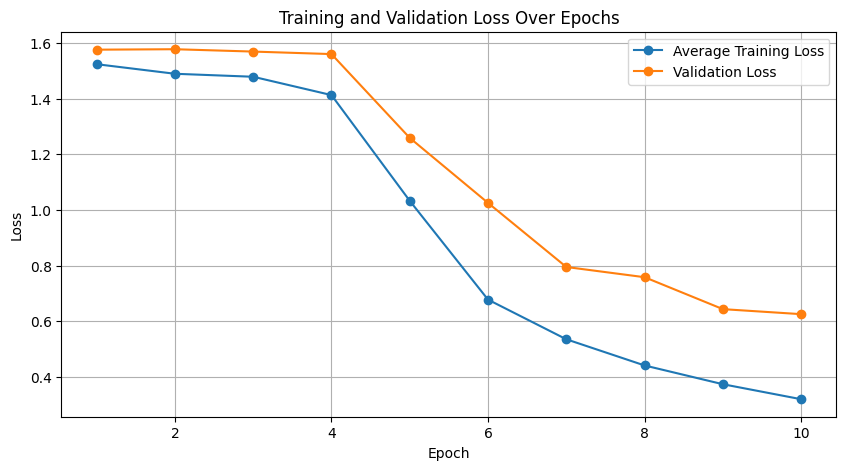

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_over_epochs(training_loss, val_losses):

    if len(training_loss) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")
    
    epochs = list(range(1, len(training_loss) + 1))
    
    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': training_loss,
        'Validation Loss': val_losses
    })
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_over_epochs(training_loss, validation_loss)